In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
#import time
from collections import Counter
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
from scipy.cluster.hierarchy import dendrogram, linkage
import math

In [2]:
path = '/Users/stevenfelix/Dropbox/DataScience/Projects/PsychologyToday/data/'
data = pd.read_pickle(path+'psychologytoday.pkl')
with open(path + "profiledict.json", "r") as fd:
    profiledict = json.load(fd)
with open(path + "profilefeaturesdict_bool_dict.json", "r") as fd:
    featuresdict = json.load(fd)

# What are the most common issues treated by Boston  providers?

In [3]:
def plot_counts(dictinfo):
    i = 0
    c = 2
    r = int(math.ceil(len(dictinfo) / 2))
    fig = plt.figure(figsize = [20,25])
    for k in dictinfo:
        i += 1
        counter = Counter(dictinfo[k]['counts'])
        top = counter.most_common(20)
        y_pos = np.arange(len(top))
        newplt = fig.add_subplot(r,c,i)
        newplt.barh(y_pos, zip(*top)[1], align='center', alpha=0.7)
        newplt.set_yticks(y_pos);
        newplt.set_yticklabels(zip(*top)[0])
        newplt.set_xlabel('Number of providers endorsing')
        newplt.set_title(k)
    fig.subplots_adjust(wspace = .5)
    fig.suptitle("Top 20 most endorsed responses for 4 variables", fontsize="large")

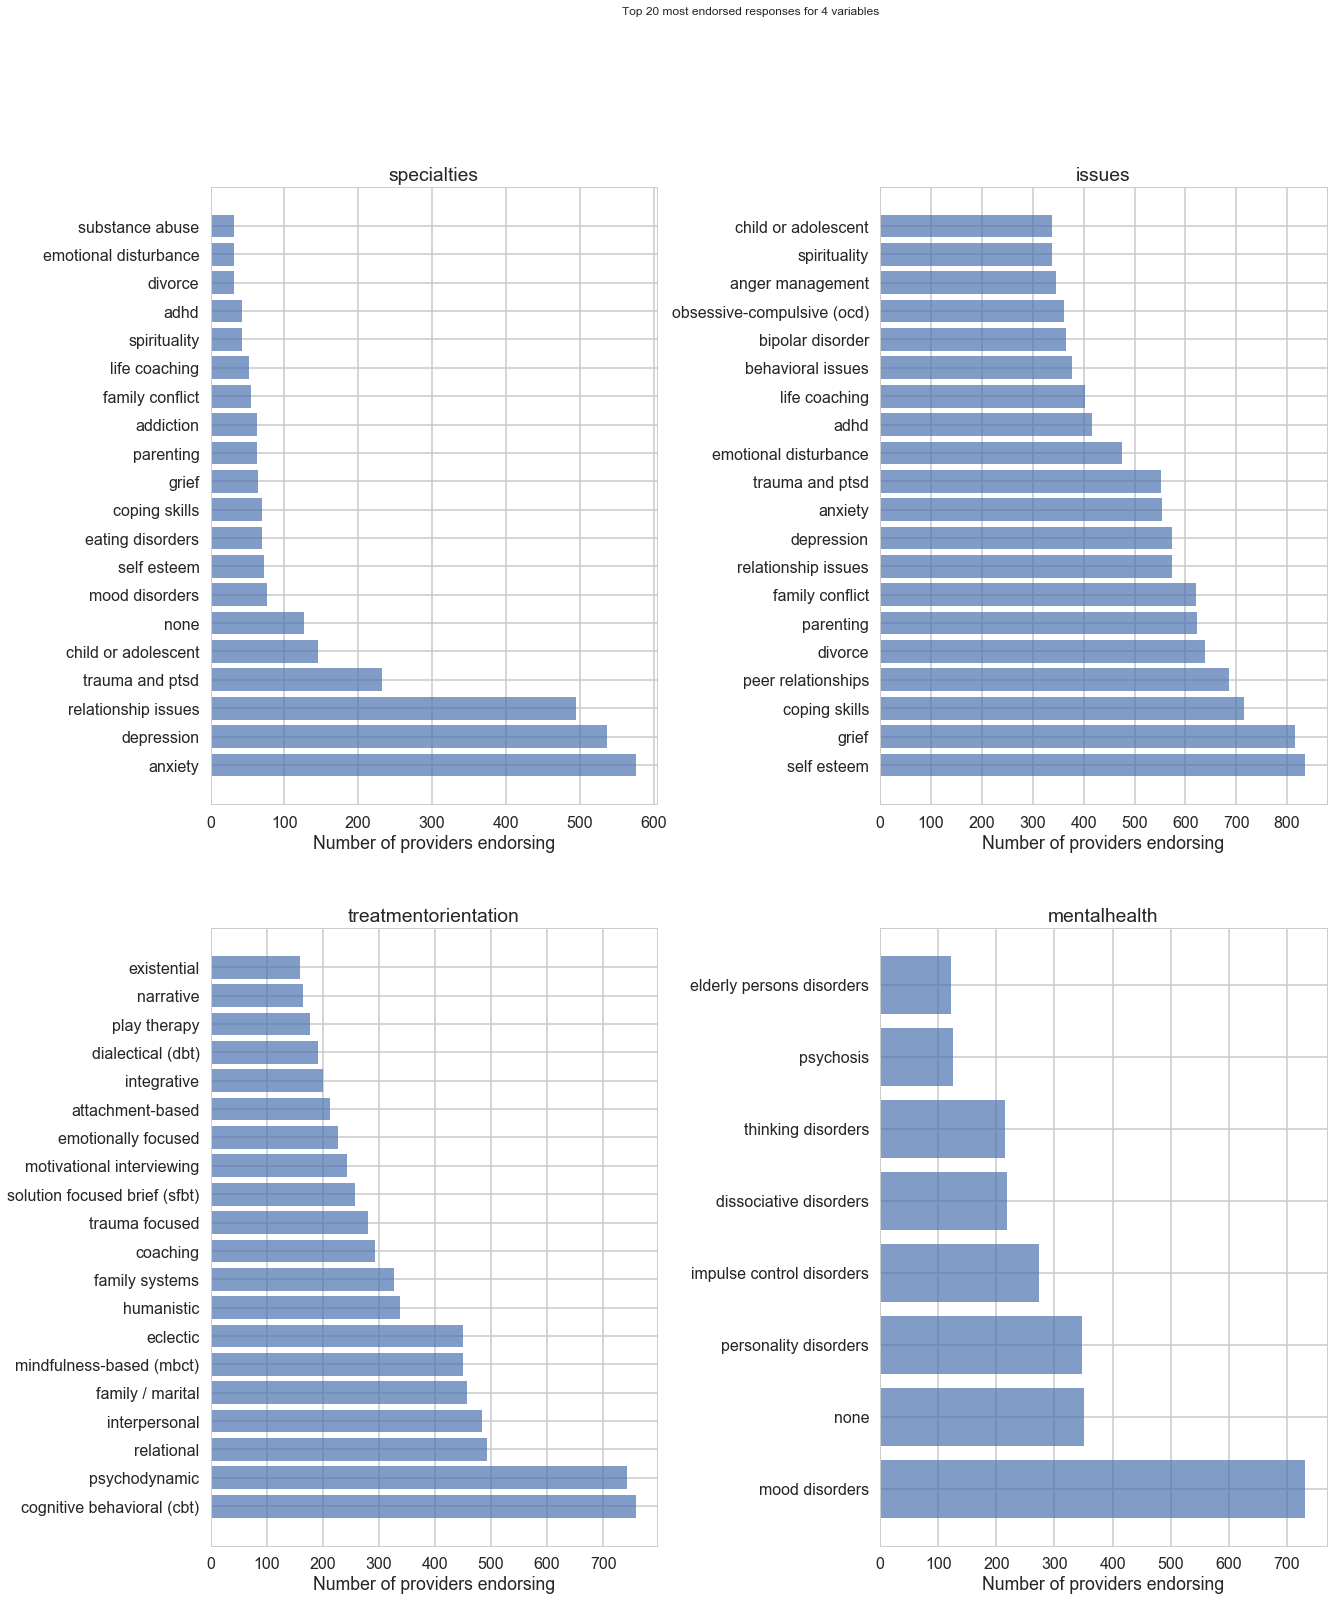

In [4]:
plot_counts(profiledict)

A few interesting things emerge:
1. The lack of symmetry between issues and specialties. When forced to choose only 3 (or fewer) 'specialties', people--by a wide margin--choose relationship issues, depression, and anxiety. But in a category where people can be more liberal with the number of things they treat, these top 3 specialties are ranked #8-10.  To put this another way, lots of providers (>60%) say they work with issues related to self-esteem, grief, and coping skills (the top 3 issues), but only a small number of providers select these problems as their specialties. One possible reason for this that these issues are common components of many larger issues (i.e, regardless of what you specialize in, you end up doing some work with self-esteem).
2. Among the top issues (relationship issues, family conflict, parenting, divorce, and peer relationships), common denominator appears to be problems in social relationships.
3. 'Mental health' is a very limited and contrived category. PsychologyToday must may limit choices just to those listed in the chart, so many paroviders leave this blank ('none').
4. And when it comes to treatment orientations, psychodynamic and CBT are by far the most common, followed by three 'relational' approaches.

Now, you may be wondering how many treatment orientations or issues that each provider can endorse (Specialties is limited to 3, and mental health appears to be limited to only 7 options, not counting non-response).

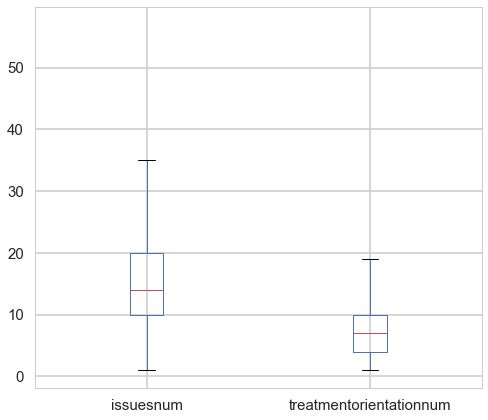

In [9]:
data[['issuesnum','treatmentorientationnum']].plot(kind = 'box', figsize = (8, 7), fontsize = 15)

*Issues*: Providers deal with 10-20 main issues, on average

*Orientations*: Providers subscribe to 5-10 treatment orientations. (Is this alot?)

## How can we make sense of this data?

Important questions we might want to explore:
- how are treatment orientations connected? Network analysis?
- What are the relevent dimensions in which therapists vary (given say, a certain Speciality: What are the relevent dimensiosn in which Depression therapists differ?)
- Do people's treatment orientations, specilaities, or issues vary by how long they've been practicing (ie how old they are?)
- Do the popularity of various treatment orientations or specialties vary by geography?
- What best predicts how much a therapist costs?  Their treatment experience? The diversity of what they treat (or rather, the specificity)? Geography? Their specialty?  Their degree (phd, counselor, etc.?)

# Exploratory Clustering

### Finding "Issue" Clusters

In [60]:
issues = pd.DataFrame(featuresdict['issues'])

In [61]:
Counter(issues['none'])[1] # number of providers who listed NO issues whatsoever, 
                            #lets remove then

37

In [62]:
issues.drop(issues.none[issues.none == 1].index, inplace = True)
issues.drop('none',inplace= True, axis = 1)

In [63]:
a = issues.sum(axis=1) # total number of issues per provider
a[a == 0].count() # number of providers with no listed issues in their pro

7

Some providers (7 in total) have 0 issues that we included in our list of the top 72 issues. Since many of these providers likely included other issues, we will create a new variable 'other' that conveys the idea that these providers likely treat less-commonly-treated issues. This will also prevent problems when computing our distance metric.

In [64]:
issues['other'] = 0
issues['other'][a==0] = 1
Counter(issues['other']) # should equal 7

Counter({0: 1173, 1: 7})

The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

In [65]:
ind = issues.index

In [84]:
Z = linkage(issues, method='complete', metric = 'dice')

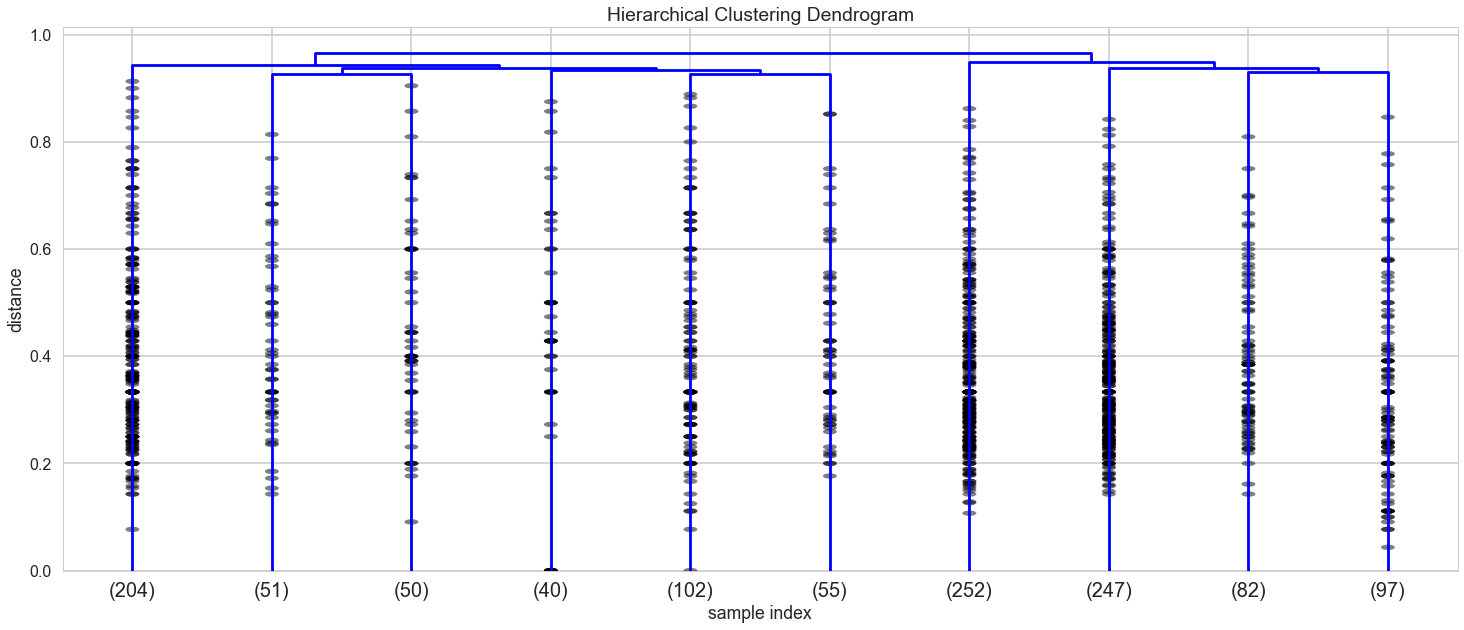

In [85]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    #leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [88]:
from scipy.cluster.hierarchy import fcluster
k=8
clusters = fcluster(Z, k, criterion='maxclust')

In [89]:
Counter(clusters)

Counter({1: 204, 2: 101, 3: 40, 4: 157, 5: 252, 6: 247, 7: 82, 8: 97})

In [90]:
issues['clust_sm_comp_20'] = clusters

In [91]:
data_full = pd.concat([data,issues], axis=1, join = 'inner', join_axes=[data.index])
data_full = data_full.loc[ind] # lets just keep rows that had values

### Explore "Issues" clusters

In [92]:
data_full_gb = data_full.groupby(['clust_sm_comp_20'])

In [93]:
issue_cols = list(issues.columns)
issue_cols.remove('clust_sm_comp_20')

In [95]:
k = issues.clust_sm_comp_20.max()

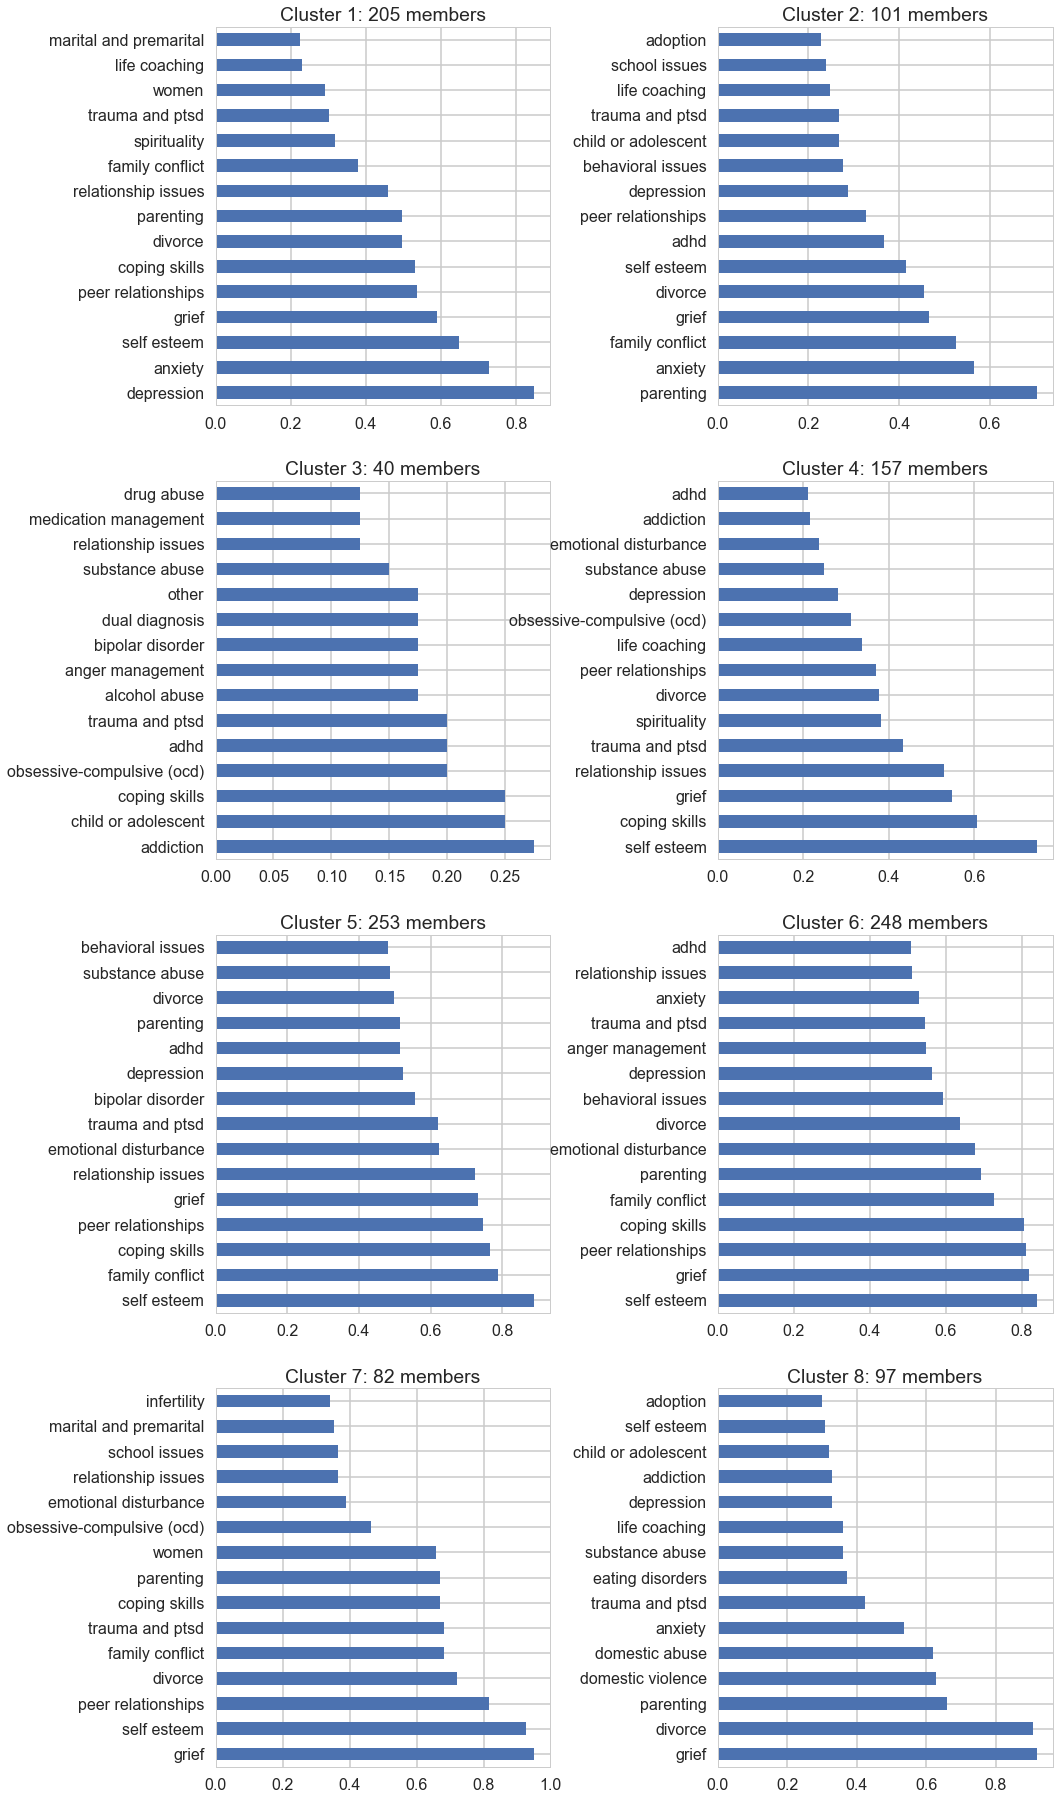

In [96]:
i = 0
#fig = plt.figure(figsize=(25,50))
k = issues.clust_sm_comp_20.max()
fig, newplt = plt.subplots(int(math.ceil(k/2.0)), 2)
fig.set_size_inches(15,k*4)
for clus,d in data_full_gb:
    r = int(math.floor(i/2))
    c = i%2
    i += 1
    cnt = d.url.count()
    pct = d[issue_cols].sum().sort_values(ascending=False)[:15] / cnt
    x_ax = np.arange(0,1.1,.2)
    pct.plot(kind='barh', ax = newplt[r,c])
    #pct.index, ha='center', va='bottom')
    #newplt[r,c].set_xticks(x_ax);
    #x_pos = np.arange(len(pct))
    #newplt = fig.add_subplot(r,c,i)
    #newplt.bar(pct)
    #newplt[r,c].set_xticks(x_pos)
    #newplt.text(x_pos, pct.values, 
    
    #newplt.set_xticklabels(pct.index, rotation=90)
    #newplt.set_aspect(aspect = 6.0)
    newplt[r,c].set_title('Cluster %d: %d members' % (clus, cnt))
    #newplt.tick_params(labelsize=10)
    #if clus == 4.0: break
fig.subplots_adjust(wspace = .5)
#fig.suptitle("15 most endorsed Issues per cluster", fontsize=30)
#fig.tight_layout()

### Results

#### Sokalmichener + complete linkage
- Hard to see much jump out 00

#### Dice + complete linkage, cut at 8 clusters
- There are some nice patterns here. 
 - Cluster 1: depression and anxiety
 - Cluster 2: anxiety and family issues
 - Cluster 3: people who listed very few issuews
 - Clustes 4 - 6: Mostly the generic providers who focused on the issues of grief, self-esteem, coping skills (the 3 most common issues in the entire sample). Hard to distinguish these, but they may be characterized as the providers who treat the 'most common' everyday-person's problems.
 - Cluster 7 is also concerned with family and relationships too, but perhaps a lot more on younger women's relationship problems -- including infertility.
 - Cluster 8 appears to be family/relationship focused, particularly on divorce, violence, abuse, parenting and grief.
 

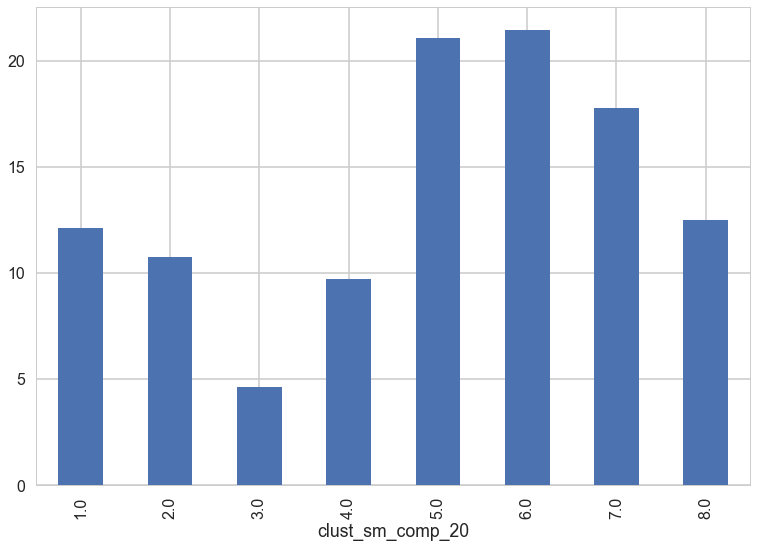

In [97]:
data_full_gb.issuesnum.mean().plot(kind = 'bar')

Clearly there are sum clusters that just list everything (the average number of items listed by people in cluster 1 is 42!!)

## Exploring Specialties Clusters

### Finding "Specialty" Clusters

In [107]:
specialties = pd.DataFrame(featuresdict['specialties'])

In [108]:
specialties.head()

,addiction,adhd,anger management,anxiety,asperger,behavioral issues,career counseling,child or adolescent,chronic pain,coping skills,depression,divorce,eating disorders,emotional disturbance,family conflict,gay,grief,life coaching,life transitions,marital and premarital,medication management,mood disorders,none,obsessive-compulsive (ocd),parenting,peer relationships,relationship issues,self esteem,sex therapy,spirituality,substance abuse,testing and evaluation,trauma and ptsd,women
Aaron Rezendes,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Abby Blackburn,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Abigail McNally,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
About Motherhood,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Adam H Wannie,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Note: since people can list no more than 3 specialties, these data are rather sparse.

In [109]:
Counter(specialties['none'])[1] # number of providers who listed NO specialties whatsoever, 
                            #lets remove then

125

In [114]:
specialties.drop(specialties.none[specialties.none == 1].index, inplace = True)
specialties.drop('none',inplace= True, axis = 1)

In [115]:
a = specialties.sum(axis=1) # total number of specialties per provider
a[a == 0].count() # number of providers with no listed specialties in their profile

6

Some providers (6 in total) have 0 specialties that we included in our list of the top 33 specialties. Since many of these providers likely listed specialties other than the top 33 we included, we will create a new variable 'other' that conveys the idea that these providers have  less common specialties. This will also prevent problems when computing our distance metric.

In [125]:
specialties['other'] = 0
specialties['other'][a==0] = 1
Counter(specialties['other']) # should equal 6

Counter({0: 1086, 1: 6})

The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

In [65]:
ind = issues.index

In [171]:
Z = linkage(specialties, method='average', metric = 'dice')

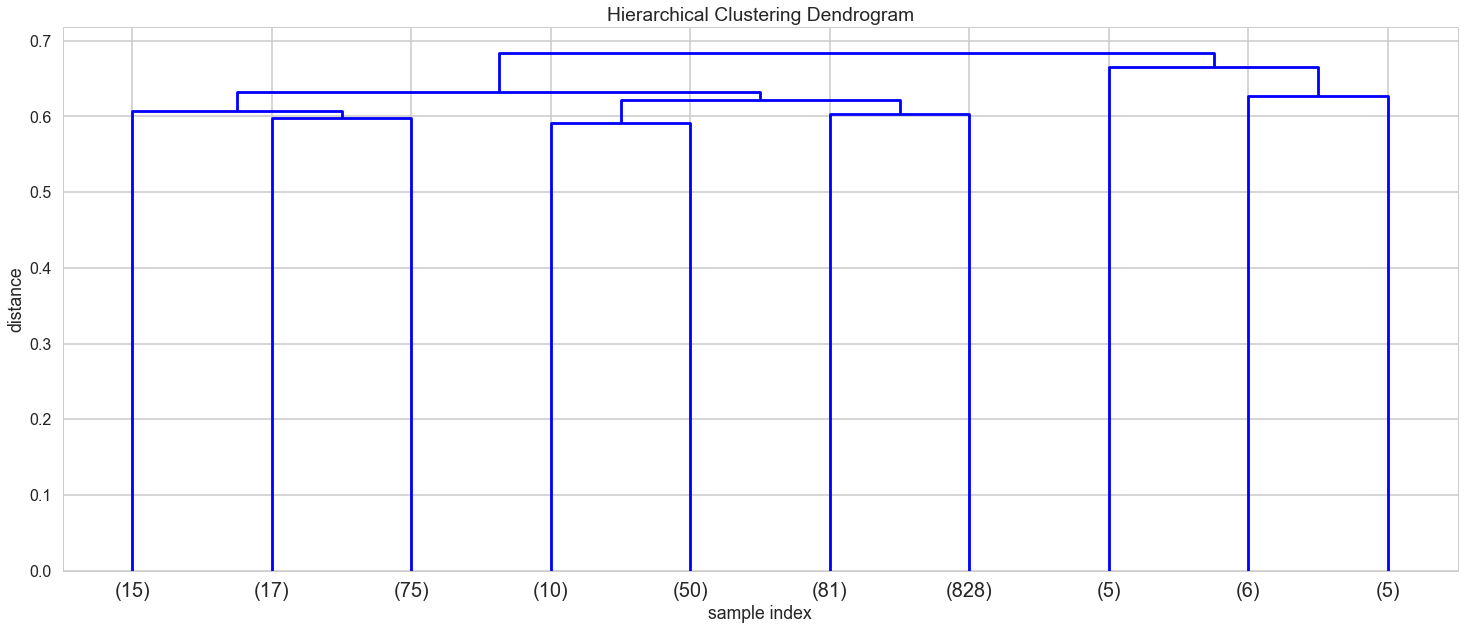

In [174]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    #leaf_rotation=90.,
    leaf_font_size=20.,
    #show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [175]:
k=10
clusters = fcluster(Z, k, criterion='maxclust')

In [176]:
Counter(clusters)

Counter({1: 15, 2: 17, 3: 75, 4: 10, 5: 50, 6: 81, 7: 828, 8: 5, 9: 6, 10: 5})

In [177]:
specialties['clusters'] = clusters

In [178]:
data_full = pd.concat([data,specialties], axis=1, join = 'inner', join_axes=[data.index])
data_full = data_full.loc[ind] # lets just keep rows that had values

### Explore "Specialty" clusters

In [179]:
data_full_gb = data_full.groupby(['clusters'])

In [180]:
specialties_cols = list(specialties.columns)
specialties_cols.remove('clusters')

In [181]:
k = specialties.clusters.max()

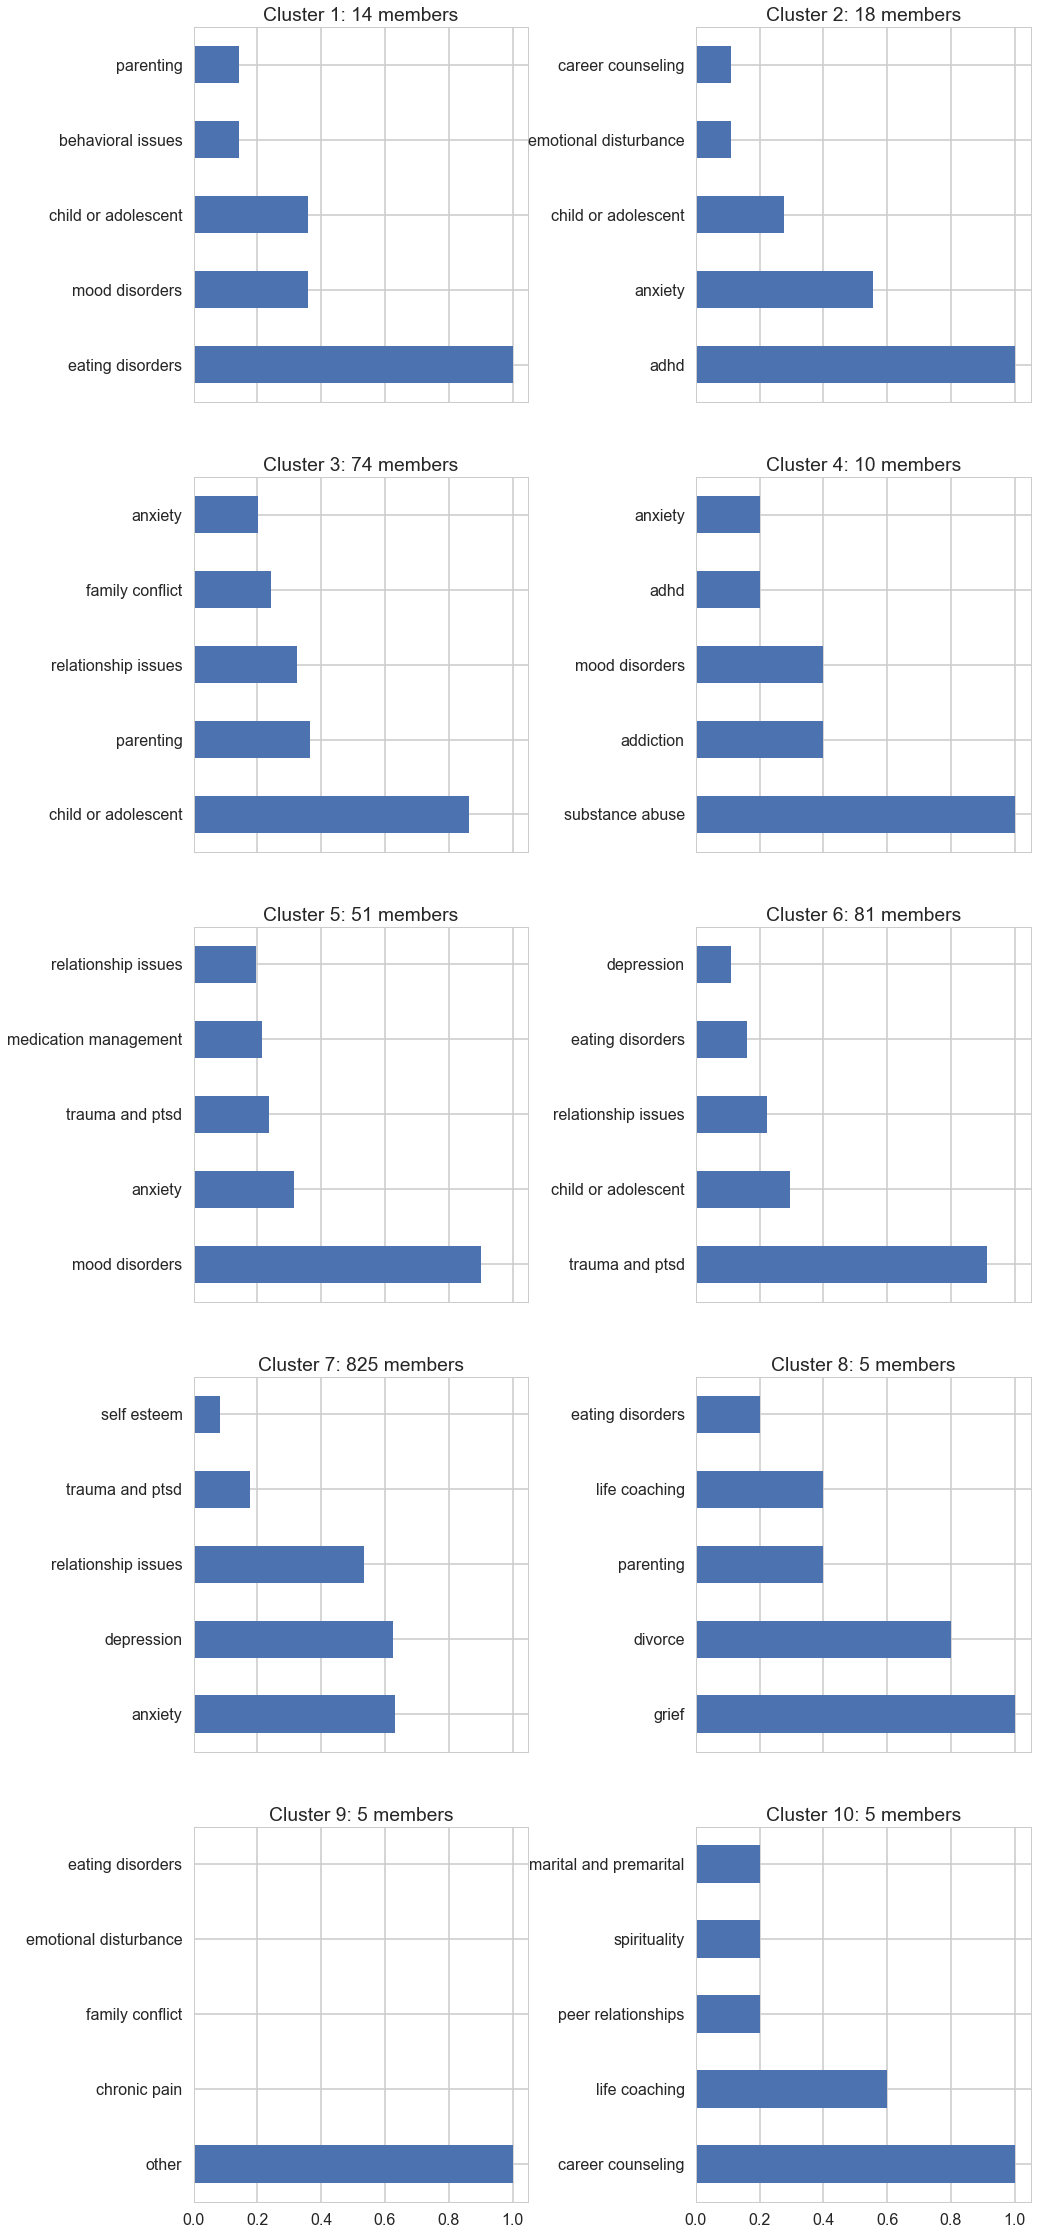

In [183]:
i = 0
#fig = plt.figure(figsize=(25,50))
k = specialties.clusters.max()
fig, newplt = plt.subplots(int(math.ceil(k/2.0)), 2, sharex= True)
fig.set_size_inches(15,k*4)
for clus,d in data_full_gb:
    r = int(math.floor(i/2))
    c = i%2
    i += 1
    cnt = d.url.count()
    pct = d[specialties_cols].sum().sort_values(ascending=False)[:5] / cnt
    x_ax = np.arange(0,1.1,.2)
    pct.plot(kind='barh', ax = newplt[r,c])
    #pct.index, ha='center', va='bottom')
    #newplt[r,c].set_xticks(x_ax);
    #x_pos = np.arange(len(pct))
    #newplt = fig.add_subplot(r,c,i)
    #newplt.bar(pct)
    #newplt[r,c].set_xticks(x_pos)
    #newplt.text(x_pos, pct.values, 
    
    #newplt.set_xticklabels(pct.index, rotation=90)
    #newplt.set_aspect(aspect = 6.0)
    newplt[r,c].set_title('Cluster %d: %d members' % (clus, cnt))
    #newplt.tick_params(labelsize=10)
    #if clus == 4.0: break
fig.subplots_adjust(wspace = .5)
#fig.suptitle("15 most endorsed Issues per cluster", fontsize=30)
#fig.tight_layout()

### Results


#### Dice + complete linkage, cut at 8 clusters


# Miscellaneous

In [ ]:
orientation = pd.DataFrame(featuresdict['treatmentorientation'])

In [ ]:
dfissues_full = pd.concat([data,TFdfs['issues']], axis=1, join = 'inner', join_axes=[data.index])

In [ ]:
dforientation_full = pd.concat([data,orientation], axis=1, join = 'inner', join_axes=[data.index])

In [ ]:
numeric = ['years', 'fee']

In [ ]:
gbdf = dforientation_full.groupby('cognitive behavioral (cbt)')
gbdf[numeric].mean()

In [ ]:
gbdf = dforientation_full.groupby('psychodynamic')
gbdf[numeric].mean()